# 3 - Conditioning the lyrics generation by artist's name

We implement a word-level LSTM french rap lyrics generator, conditionned by artist name

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
'''
the first step is to read the lyric corpus,
removing the ponctuation and spliting it into words

'''
import glob
from tqdm import tqdm 
import os

lyrics_path = '/content/drive/MyDrive/ProjetDL/lyrics/*.txt'
lyrics_path_bis = '/content/drive/MyDrive/ProjetDL/lyricsbis/*.txt'


files = glob.glob(lyrics_path_bis)
corpus_by_artists = { }
total_corpus = []
artists_list = []
for file in tqdm(files, position=0, leave=True) :
    with open(file) as f :
        text = f.read().lower().replace('\n', ' \n ')
        text_in_words = [w for w in text.split(' ') if w.strip() != '' or w == '\n']
        corpus = text_in_words
        total_corpus = total_corpus + corpus
        artist_txt = os.path.basename(f.name)
        artist = os.path.splitext(artist_txt)[0]
        artists_list.append(artist)
    corpus_by_artists[artist] = corpus

n_artists = len(artists_list)
print('')
print('# Artists:',n_artists, ", ".join(artists_list))

100%|██████████| 54/54 [00:21<00:00,  2.51it/s]


# Artists: 54 alkpote, booba, bosh, lucio bukowski, demi portion, dinos, disiz, hatik, doc gynéco, dosseh, hippocampe fou, hornet la frappe, kery james, la fouine, gambi, kaaris, gradur, grand corps malade, kacem wapalek, kalash criminel, koba lad, kool shen, lacrim, niro, niska, leto, orelsan, plk, lomepal, lord esperanza, oxmo puccino, mac tyer, rohff, mc solaar, sinik, médine, soprano, mister you, still fresh, sultan, tsew the kid, alpha wann, naps, youssoupha, naza, nekfeu, fonky family, hocus pocus, mz, pnl, psy 4 de la rime, stupeflip, suprême ntm, damso


In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(artists_list)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [ ]:
for key in corpus_by_artists :
  print("There are",len(corpus_by_artists[key]),"words in",key,"corpus")

print("total of",len(total_corpus),"words")

There are 121890 words in alkpote corpus
There are 112572 words in booba corpus
There are 31591 words in bosh corpus
There are 96620 words in lucio bukowski corpus
There are 89038 words in demi portion corpus
There are 59911 words in dinos corpus
There are 116532 words in disiz corpus
There are 72618 words in hatik corpus
There are 25547 words in doc gynéco corpus
There are 93825 words in dosseh corpus
There are 41833 words in hippocampe fou corpus
There are 44963 words in hornet la frappe corpus
There are 105795 words in kery james corpus
There are 136780 words in la fouine corpus
There are 113730 words in gambi corpus
There are 133490 words in kaaris corpus
There are 68170 words in gradur corpus
There are 60589 words in grand corps malade corpus
There are 29947 words in kacem wapalek corpus
There are 45057 words in kalash criminel corpus
There are 48460 words in koba lad corpus
There are 29649 words in kool shen corpus
There are 148689 words in lacrim corpus
There are 130627 words i

In [ ]:
'''
Now we compute the word frequency of our corpus
and we remove the words that appear less than a 
chosen threshold : they will be of no interest
for the learning of the algorithm
'''

word_freq = {}
for word in total_corpus:
    word_freq[word] = word_freq.get(word, 0) + 1

MIN_WORD_FREQUENCY = 10 # this is already huge, but we have a lot of words...

ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)

words = set(total_corpus)
print('Unique words before ignoring:', len(words))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
words = sorted(set(words) - ignored_words)
print('Unique words after ignoring:', len(words))

word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))

Unique words before ignoring: 215562
Ignoring words with frequency < 10
Unique words after ignoring: 25680


In [ ]:
'''
We will teach our Neural network to predict the next word
given a sequence of previous word, of a chosen length.
'''

STEP = 4 # we only pick one word every five other
artists = []
sentences = []
next_words = []
ignored = 0

SEQUENCE_LEN = 15
for key in corpus_by_artists :
  for i in tqdm(range(0, len(corpus_by_artists[key]) - SEQUENCE_LEN, STEP), position=0, leave=True):
      # Only add sequences where no word is in ignored_words
      if len(set(corpus_by_artists[key][i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
          artists.append(key)
          sentences.append(corpus_by_artists[key][i: i + SEQUENCE_LEN])
          next_words.append(corpus_by_artists[key][i + SEQUENCE_LEN])
      else:
          ignored = ignored+1
print('')
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))

100%|██████████| 2946/2946 [00:00<00:00, 413023.35it/s]


Ignored sequences: 736752
Remaining sequences: 340536


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def shuffle_and_split_training_set(artists_original,sentences_original, next_original, percentage_test=10):
    # shuffle at unison
    print('Shuffling sentences')

    tmp_sentences = []
    tmp_next_word = []
    tmp_artists = []
    for i in np.random.permutation(len(sentences_original)):
        tmp_sentences.append(sentences_original[i])
        tmp_next_word.append(next_original[i])
        tmp_artists.append(artists_original[i])

    cut_index = int(len(sentences_original) * (1.-(percentage_test/100.)))

    # we put the artist name at the first place of the training object
    cat_train,x_train, cat_test,x_test = tmp_artists[:cut_index],tmp_sentences[:cut_index],tmp_artists[cut_index:],tmp_sentences[cut_index:]
    y_train, y_test = tmp_next_word[:cut_index], tmp_next_word[cut_index:]

    print("Size of training set = %d" % len(x_train))
    print("Size of test set = %d" % len(y_test))
    return (cat_train, x_train, y_train), (cat_test, x_test, y_test)

(artists_train, sentences_train, next_words_train), ( artists_test, sentences_test, next_words_test) = shuffle_and_split_training_set(artists,sentences, next_words)


Shuffling sentences
Size of training set = 306482
Size of test set = 34054


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15, 25680)]  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          13181440    input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           1100        input_1[0][0]                    
______________________________________________________________________________________________

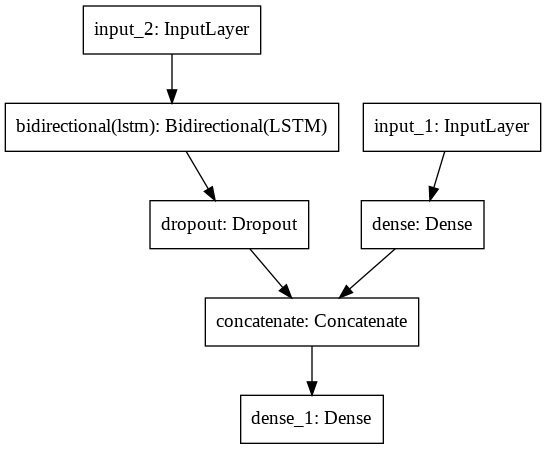

In [ ]:
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping           
from keras.models import Sequential                                                  
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding  
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense
from keras.models import Model

dropout = 0.2

artist_input= Input((n_artists,))
dense_layer = Dense(20,activation="sigmoid")(artist_input)

lyrics_input = Input((SEQUENCE_LEN, len(words)))
lstm_layer = Bidirectional(LSTM(64), input_shape=(SEQUENCE_LEN, len(words)))(lyrics_input)
dropout_layer = Dropout(dropout)(lstm_layer)
concat_layer= Concatenate()([dense_layer, dropout_layer])

output = Dense(len(words),activation="softmax")(concat_layer)

model = Model(inputs=[artist_input,lyrics_input], outputs=output)
model.compile(loss='sparse_categorical_crossentropy',
                optimizer="adam", metrics=['accuracy'])
model.summary()

import tensorflow as tf
tf.keras.utils.plot_model(model)

In [ ]:
# we need data generators to feed the model
# otherwise it would cause a memory error
import numpy as np
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from operator import itemgetter

BATCH_SIZE = 32

def generator_eti(artist_list,sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        a = np.zeros((batch_size, n_artists), dtype=np.bool)
        x = np.zeros((batch_size, SEQUENCE_LEN, len(words)), dtype=np.bool)
        y = np.zeros((batch_size), dtype=np.int)
        for i in range(batch_size):
            a[i] = lb.transform([artist_list[index % len(sentence_list)]])[0]
            for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                x[i, t, word_indices[w]] = 1
            y[i] =  word_indices[next_word_list[index % len(sentence_list)]]
            index = index + 1
        yield [a,x], y

In [ ]:
[a,X],y = next(generator_eti(artists,sentences, next_words, BATCH_SIZE))

print(a.shape,X.shape, y.shape)
print(y)

(32, 54) (32, 15, 25680) (32,)
[18364     0  9875  9875  9875 17531 17531 17531 17531   422 23890   455
  1451 23544 12996     0 17531 21958 10671     0 24161  6816 22400  4810
 12996 22012  3006 23756  5342 10973  5296 12996]


In [ ]:

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
#file_path = '/content/drive/MyDrive/ProjetDL/Model_2'     #Changer le nom avant pleeeeease mdr
model_checkpoint = ModelCheckpoint(filepath=file_path + '.hdf5', monitor='val_accuracy',
                                                   save_best_only=True)

callbacks_list = [early_stopping,model_checkpoint]

model.fit_generator(generator_eti(artists_train,sentences_train, next_words_train, BATCH_SIZE),
                    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
                    epochs=100, # at least 20 should be needed
                    callbacks=callbacks_list,
                    validation_data=generator_eti(artists_test,sentences_test, next_words_test, BATCH_SIZE), 
                    validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10642/10642 [==============================] - 323s 30ms/step - loss: 6.8522 - accuracy: 0.1201 - val_loss: 5.9961 - val_accuracy: 0.1656
Epoch 2/100
10642/10642 [==============================] - 314s 30ms/step - loss: 5.6918 - accuracy: 0.1747 - val_loss: 5.6738 - val_accuracy: 0.1908
Epoch 3/100
10642/10642 [==============================] - 309s 29ms/step - loss: 5.1201 - accuracy: 0.2153 - val_loss: 5.5659 - val_accuracy: 0.2048
Epoch 4/100
10642/10642 [==============================] - 303s 28ms/step - loss: 4.6143 - accuracy: 0.2596 - val_loss: 5.5749 - val_accuracy: 0.2135
Epoch 5/100
10642/10642 [==============================] - 302s 28ms/step - loss: 4.1301 - accuracy: 0.3113 - val_loss: 5.6592 - val_accuracy: 0.2204
Epoch 6/100
10642/10642 [==============================] - 306s 29ms/step - loss: 3.6246 - accuracy: 0.3664 - val_loss: 5.7691 - val_accuracy: 0.2257
Epoch 7/100
10642/10642 [==============================] - 302s 28ms/step - loss: 3.1717 - accuracy:

KeyboardInterrupt: ignored

In [ ]:
#I use a loaded model with only 5 epochs to generate text
#reconstructed_model = keras.models.load_model('/content/drive/MyDrive/ProjetDL/model20')

file_path = '/content/drive/MyDrive/ProjetDL/Model_2'
#Faut execute la cell de la création du modèle plus haut avant
model.load_weights(file_path + '.hdf5')

In [ ]:
seed1 = ['juge','que','j','ai','vu','avait','plus','de','vice','que','le','dealer','de','ma','rue']
seed2 = ['me','fait','craquer', '\n','ce','n','est','qu','un','dessin','mais','je','veux','l','aimer']
seed3 = ['yo','yo','yo','je','pense','pas','à','demain',',','parce','que','demain','c','est','loin']
len(seed3)

15

In [ ]:
seed_index = np.random.randint(len(sentences))
seed = sentences[seed_index]
seed = ['mes', 'textes', 'sont', 'écrits', 'par', 'une', 'machine', '\n', 'mon', 'sons', 'vient', 'de', 'la', 'rue', 'gros']
seed = seed3
# rapper = lb.transform([artists[seed_index % len(sentences)]])
rapper = lb.transform(['booba'])
rapper_bis = lb.transform(['oxmo puccino'])
print(seed)
print(lb.inverse_transform(rapper))
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

for diversity in [0.4, 0.5, 0.6]:
    sentence = seed
    sentence_bis = seed

    lyric = []
    lyric_bis = []
    for i in range(100):
        x_pred = np.zeros((1, SEQUENCE_LEN, len(words)))
        x_pred_bis = np.zeros((1, SEQUENCE_LEN, len(words)))

        for t, word in enumerate(sentence):
            x_pred[0, t, word_indices[word]] = 1.

        for t, word in enumerate(sentence_bis):
            x_pred_bis[0, t, word_indices[word]] = 1.

        preds = model.predict([rapper,x_pred], verbose=0)[0] # reconstructed_model or model
        preds_bis = model.predict([rapper_bis,x_pred_bis], verbose=0)[0]

        next_index = sample(preds, diversity)
        next_word = indices_word[next_index]

        next_index_bis = sample(preds_bis, diversity)
        next_word_bis = indices_word[next_index_bis]

        sentence = sentence[1:]
        sentence.append(next_word)

        sentence_bis = sentence_bis[1:]
        sentence_bis.append(next_word_bis)

        lyric.append(next_word)
        lyric_bis.append(next_word_bis)
    print('generation pour température',diversity,':')
    print(' '.join(lyric))
    print('')

    print('generation pour température',diversity,':')
    print(' '.join(lyric_bis))
    print('')


['yo', 'yo', 'yo', 'je', 'pense', 'pas', 'à', 'demain', ',', 'parce', 'que', 'demain', 'c', 'est', 'loin']
['booba']
generation pour température 0.4 :

 mais aujourd'hui sans se faire, quand je ne cherche jamais 
 la vie est un peu d'elle 
 on est là, dans la tête 
 on est tous les vrais qui veulent faire la guerre 
 les gens sont les vrais sont sont remplis de pute 
 fais la guerre 
 les sont en chien de la nuit 
 je suis là où je suis au placard de la rue 
 de mon père et les vrais qui parlent de mon père 
 le rap de la vie, la vie est comme un coup 
 tu sais qu'c'est la

generation pour température 0.4 :

 mais trop ce n'est pas chez nous 
 c'est pas pour les mêmes hommes 
 c'est pas de la vie 
 c'est qu'une seule seule fois qu'on ne peut pas faire ce que c'est ce qu'il est un crime 
 à moi on est toujours en bas de la merde 
 et de la vie à la main, on va se faire 
 on est partie de la vie 
 on va faire des gens 
 on va se faire 
 on va tous les boss 
 on va faire la guerre 
 on va